# Decision Tree Regressor with Traditional Transfer

In diesem Notebook wird ein _Decision Tree Regressor_ auf das Zieldatenset angewendet und mithilfe von Traditionellem Transfer ergänzt.

## Table of Contents

# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import re
import tensorflow as tf
from tqdm import tqdm

# Preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import nltk

# Preprocess features
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('stopwords')

# Preprocess targets
from sklearn.preprocessing import MinMaxScaler

# Decision Tree for regression
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Transfer 
import sklearn.metrics
from cvxopt import matrix, solvers
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
import argparse
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import pairwise_distances
from scipy.stats import wasserstein_distance
import time
from multiprocessing import Process, Queue

# Evaluation
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

# Visulization
import matplotlib.pyplot as plt
from sklearn_evaluation import plot

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-07-02 14:44:43.587495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/leamayer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading

Zunächst wird das kanadische Youtube-Datenset aus dem Jahr 2012 als das Zieldatenset für dieses Projekt festgelegt. Alle anderen Files werden als Quelldaten verwendet. 

Darüber hinaus findet hier ein entscheidender Teil des Transfer Learnings statt. Mithilfe der ***Wasserstein Distance*** wird jeden Quelldatenset mit dem Targetdatenset verglichen. Je geringer dieser Wert, desto ähnlicher sind sich die Datensätze. Dementsprechend wird hier eine Auswahl des am besten zu den Zieldaten passensten Datensätze getroffen. Die Strenge dieser Bewertung kann mit dem threshold Parameter angepasst werden.

Anschließend werden die textuellen Attribute der Videos als Features und die Views der Videos als Target ausgewählt. 

In [2]:
# Select Target Dataset

target_file = "CAvideos_12.csv"

df_target = pd.read_csv("../Data/processed_data/"+target_file)
df_target = df_target.dropna()

df_target = df_target [["channel_title","tags","description","title","views"]]

df_target["views"] = df_target["views"].astype(int)

# Create Source Data Set

folder_path = "../Data/processed_data"  # Path to processed df
iterator = 0

frames = []
was_list = []

threshold = 2000000

it = 0

# Iterate over files in the folder
for file_name in os.listdir(folder_path):

    if file_name.endswith('.csv') and file_name != target_file:  # Process only CSV files

        df = pd.read_csv("../Data/processed_data/"+file_name)
        df = df.dropna()

        df = df [["channel_title","tags","description","title","views"]]

        df["views"] = df["views"].astype(int)

        # Select the best fitting datasets

        was = wasserstein_distance( df_target["views"], df["views"])

        was_list.append(was)

        if was > threshold:
            frames.append(df)
            it += 1

df_source = pd.concat(frames)

print(f">>> Created target df ({len(df_target)}) and source df containing the {it} best fitting datasets ({len(df_source)})")

>>> Created target df (6037) and source df containing the 7 best fitting datasets (31938)


In [3]:
# Loas features and targets

# Target df
feature_df_tar = df_target [["channel_title","tags","description","title"]]  # Text data as numpy list
targets_tar = df_target["views"].to_numpy()  # Target data as numpy list

# Source df
feature_df = df_source [["channel_title","tags","description","title"]]  # Text data as numpy list
targets = df_source["views"].to_numpy()  # Target data as numpy list


## Preprocessing

Im folgenden werden die Quell- und Zieldaten seperat verarbeitet. Erst nach der Durchführung des Test-Train-Splits werden die Ziel-Trainingsdaten mit den Quelldaten angereichert.

### Normalize Targets

Die Normalisierung der Zieldaten verbesser die Vergleichbarkeit, Interpretierbarkeit, Konsistenz und Stabilität der Vorhersage. Dafür wird im folgenden der Min-Max Scaler der Sklearn Bibliothek verwendet. Hierbei ist zu beachten den gleichen Scaler auf die Quell- und Zieldaten anzuwenden, der auf die Minn- und Max-Werte der beiden Datensets gefittet ist.

In [4]:
# Normalizing the target values with the min-max normalization

scaler = MinMaxScaler()

# Fit scales of both datsets
normalized_targets = scaler.fit_transform(np.append(targets_tar,targets).reshape(-1, 1)).flatten()

# Apply scaler to both target lists
normalized_targets = scaler.transform(targets.reshape(-1, 1)).flatten()
print(f">>> Range from original source targets ({targets.min()};{targets.max()}) has been normalized ({normalized_targets.min()};{normalized_targets.max()})")

normalized_targets_tar = scaler.transform(targets_tar.reshape(-1, 1)).flatten()
print(f">>> Range from original target targets ({targets_tar.min()};{targets_tar.max()}) has been normalized ({normalized_targets_tar.min()};{normalized_targets_tar.max()})")

>>> Range from original source targets (9012;424538912) has been normalized (1.8177423368351362e-05;1.0000000000000002)
>>> Range from original target targets (1295;137843120) has been normalized (0.0;0.32468695229897615)


### Apply Stemmer and Remove Stopwords from Text Features

Um Wörter derselben Wortfamilie auf eine gemeinsame Stamm zurückführen, wird im Folgenden ein ***Stemmer*** auf die Features angewendet. Im Gegensatz zu einem Lemmatisierer, der die Wörter auf ihre Grundform reduziert, ist der Stemmer wesentlich schneller, da nur die Wortendungen entfernt werden. Dies kann zu grammatikalisch inkonsistenten Sätzen führen, was aber bei dieser Aufgabe zu vernachlässigen ist.

Des weiteren werden semantisch ***unwichtige Wörter*** (die häufig vorkommen) entfernt. Dabei wird auf die nlkt English-Stopwords-Liste zurückgegriffen. Um noch weitere Youtube-spezifische Stowords zu indentifizieren. Werden für jedes Feature 250 weitere Stopwords mithilfe des Tfidf-Scores identifiziert und zu den nlkt Stopwords hinzugefügt. Dieser Score sagt aus, ob ein Wort über alle Youtubevideos hinweg oft vorkommt und dementsprechend semmantisch unwichtig ist.


In [5]:
# Add content speficic stopwords by select the top N words with the highest TF-IDF scores as potential stopwords

def get_content_stopwords(texts):
    
    vectorizer = TfidfVectorizer() # TfidfVectorizer object from sklearn

    tfidf_matrix = vectorizer.fit_transform(texts) 

    feature_names = vectorizer.get_feature_names_out()

    avg_tfidf_scores = tfidf_matrix.mean(axis=0).tolist()[0] # Get average TF-IDF score for each word

    word_scores = list(zip(feature_names, avg_tfidf_scores))

    word_scores.sort(key=lambda x: x[1], reverse=True) # Sort the word_scores in descending order

    N = 250 # Number of stopwords to select
    stopwords_content = [word for word, score in word_scores[:N]] # Potential stopwords

    print(f">>> {len(stopwords_content)} content specific stopwords are identified")

    return stopwords_content

In [6]:
# Define stemmer and stopwords

def get_stopwords(texts):

    # Stopwords
    stop_words_nlkt = set(stopwords.words('english'))

    # add contect speficic stopwords 
    original_stopword_len = len(stop_words_nlkt)

    stop_words = stop_words_nlkt.copy()

    stop_words |= set(get_content_stopwords(texts)) # Add the additional wikipedia specific stopwords

    merged_stopword_len = len(stop_words)

    print(f">>> {merged_stopword_len-original_stopword_len} additional stopwords have been added to the nlkt stopwords list")

    return stop_words

In [7]:
# Apply Stemmer and Stopword Removal to source data

# Get Stemmer
stemmer = SnowballStemmer('english')
feature_df_preprocessed = pd.DataFrame()


for feature in feature_df:

    print(f"\n--- Preprocessing {feature} feature ---\n")

    texts = feature_df[feature].to_numpy()

    # Remove numbers and singel characters

    texts_preprocessed = [' '.join([word for word in text.split() if not word.isnumeric()]) for text in texts] # Remove numbers
    texts_preprocessed = [' '.join([word for word in text.split() if not len(word) > 1]) for text in texts] # Remove words with one character

    print(">>> Numbers and words with only one character are removed")

    # Get Stopwords
    stop_words = get_stopwords(texts)

    # Remove stop words from the text data and apply stemmer

    texts_preprocessed = [' '.join([stemmer.stem(word) for word in text.split() if word.lower() not in stop_words]) for text in texts]

    feature_df_preprocessed[feature] = texts_preprocessed

    print(">>> The Stemmer and the Stopword Removal are applied f.e.:\n")

    print (texts[5]) # show example
    print (texts_preprocessed[5])


--- Preprocessing channel_title feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 243 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

Cardi B
b

--- Preprocessing tags feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 224 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

Cardi B|"I Like It"|"Invasion of Privacy"|"Bad Bunny"|"J Balvin"|"Bronx"|"New York"|"Rap"|"Hip Hop"|"Bodak Yellow"|"Bartier Cardi"|"8zSRkr1nQNw"|"Cardi"|"Bardi"
b|"i it"|"invas privacy"|"bad bunny"|"j balvin"|"bronx"|"new york"|"rap"|"hip hop"|"bodak yellow"|"barti cardi"|"8zsrkr1nqnw"|"cardi"|"bardi"

--- Preprocessing description feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specif

In [8]:
# Show preprocessed features

feature_df_preprocessed

,channel_title,tags,description,title
0,gorillaz,"humility|""gorillaz humanz""|""th now""|""georg ben...",âhumil feat. georg benson taken brand . pre-...,gorillaz - humil (offici video)
1,,"maroon|""girls""|""like""|""you""|""interscope""|""reco...","girl youâ now.http://smarturl.it/g more, vis...",maroon 5 - girl ft. b
2,hannah stock,"wait crush watching|""hannah""|""stocking""|""wait""...",â¶ https://youtu.be/2-tzlbfotjasubscrib â¶ h...,"wait, crush watching? | hannah stock"
3,clean bandit,"clean bandit|""solo""|""demi lovato""|""i solo""|""of...",singl solo feat. demi lovato https://atlanti.c...,clean bandit - feat. demi lovato [offici video]
4,smosh,"high now|""high school""|""2008 2018""|""2008 smosh...",thing high school sure chang last years...cast...,school 2008
...,...,...,...,...
31933,logicvevo,"logic|""alessia""|""1-800-273-8255""|""khalid""|""gra...",download/stream everybodi here: http://smartur...,- 1-800-273-8255 (live 60th grammi â®) ft. ale...
31934,houzztv,"length subs|""gordon ramsay""|""christina wilson""...","gordon ramsay surpris christina wilson, friend...",houzz: gordon ramsayâ surpris renov
31935,,"a24|""a24 films""|""a24 trailers""|""independ films...",subscribe: http://bit.ly/a24subscribe\n\nfrom ...,hereditari | | a24
31936,zeddvevo,"zedd middle|""th middl zedd""|""th middl video""|""...","zedd, maren morris, grey - middl (offici video...","zedd, maren morris, grey - middl (offici video)"


In [9]:
# Apply Stemmer and Stopword Removal to target data

# Get Stemmer
stemmer = SnowballStemmer('english')
feature_df_preprocessed_tar = pd.DataFrame()


for feature in feature_df_tar:

    print(f"\n--- Preprocessing {feature} feature ---\n")

    texts = feature_df_tar[feature].to_numpy()

    # Remove numbers and singel characters

    texts_preprocessed = [' '.join([word for word in text.split() if not word.isnumeric()]) for text in texts] # Remove numbers
    texts_preprocessed = [' '.join([word for word in text.split() if not len(word) > 1]) for text in texts] # Remove words with one character

    print(">>> Numbers and words with only one character are removed")

    # Get Stopwords
    stop_words = get_stopwords(texts)

    # Remove stop words from the text data and apply stemmer

    texts_preprocessed = [' '.join([stemmer.stem(word) for word in text.split() if word.lower() not in stop_words]) for text in texts]

    feature_df_preprocessed_tar[feature] = texts_preprocessed

    print(">>> The Stemmer and the Stopword Removal are applied f.e.:\n")

    print (texts[5]) # show example
    print (texts_preprocessed[5])


--- Preprocessing channel_title feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 243 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

Snapchat
snapchat

--- Preprocessing tags feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 230 additional stopwords have been added to the nlkt stopwords list
>>> The Stemmer and the Stopword Removal are applied f.e.:

new snapchat|"version 2"|"snap inc"|"brandnew"|"update"|"software"|"snap"|"new update"|"redesign"|"reorganize"|"Snapchat"
snapchat|"vers 2"|"snap inc"|"brandnew"|"update"|"software"|"snap"|"new update"|"redesign"|"reorganize"|"snapchat"

--- Preprocessing description feature ---

>>> Numbers and words with only one character are removed
>>> 250 content specific stopwords are identified
>>> 181 additional stopwords h

In [10]:
# Show preprocessed targets

feature_df_preprocessed_tar

,channel_title,tags,description,title
0,marvel,"marvel|""comics""|""com books""|""nerdy""|""geeky""|""s...",ideaâ¦ avengers: infin war. theater may 4.\n\...,marvel studio avengers:
1,rober,"fluidiz bed|""liquid sand""|""fluid sand bed""|""po...",water fill hot tub soooo 2016. \ngo http://bit...,liquid sand tub- fluidiz air bed
2,thefishpenetr,"computer|""wallpaper""|""monitor""|""kid""|""scared""|...","friend gave wallpap dump, thought cool littl f...",i'm shook
3,fresh,"dil kareeb|""koi sala dil kareeb aun dena nahi""...",present punjabi dil kareeb garri sandhu.\n\nsu...,dil kareeb | garri sandhu ( ) | avex dhillon |
4,,"vox.com|""vox""|""explain""|""hostil architecture""|...",bench forever.\n\nsubscrib channel! http://goo...,citi uncomfort bench
...,...,...,...,...
6032,eh bee famili,"eh bee|""vine""|""vlog""|""family""|""fun""|""ehbeefami...",sponsor dentek\ncan floss 30 days? visit âºht...,floss like boss - diss track (offici video)
6033,flower,"flower tv|""uppum mulakum""|""uppum""|""biju sopana...",:- \n\nwatch flower mobil free!!! \ndownload h...,uppum mulakumâflowersâep# 507
6034,jesseandmik,"frozen dinosaur baby|""frozen dinosaur""|""dinosa...",come across frozen dinosaur babi ice quit surp...,frozen dinosaur baby!
6035,alena,[none],alena - advertis - merri happi - gift - alena,alena - advertis - happi - - alena


### Encode the Data

Im Folgenden sollen aus den Text Features, Features entstehen, die in einem Modell verarbeitet werden können.
Dazu könnten Text Features wie der Tfidf Score verwendet werden. Da hier aber die gleiche Technik wie bei den Deep Learning Modellen verwendet werden soll, um die Vergleichbarkeit zu erhalten, wird der ***Text in Sequencen*** übertragen. 

Hierfür wird zunächst ein Tokenizer angewendet um den Text in einzelne Wörter zu verlegen. Anschliend werden diese in Zahlen Sequence umgeschrieben und je eine Zahl als Spalte im Dataframe gespeichert.

In [11]:
def encoding(df):# encode remaining objects

    tokenizer = Tokenizer(
        num_words=10000,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    )

    for column in df:

        # Check if column is of type object
        if df[column].dtype == 'object' and column != "video_id":

            df[column] = df[column].astype(str)

            print(f">>> {column} is of type object and will be encoded")

            tokenizer.fit_on_texts(df[column])

            # Get the word index
            word_index = tokenizer.word_index

            # Convert texts to sequences
            sequences = tokenizer.texts_to_sequences(df[column])

            df[column] = sequences

            # Create separate columns for each element in the list
            df_expanded = pd.DataFrame(df[column].to_list(), columns=[f"{column}_{i+1}" for i in range(df[column].str.len().max())])
            
            # Concatenate expanded columns with the original DataFrame
            df = pd.concat([df.drop(column, axis=1), df_expanded], axis=1)
                
    return df
        

In [12]:
# Apply encoding to source data

encoded_df = encoding(feature_df_preprocessed.copy())

encoded_df = encoded_df.fillna(0)

encoded_df

>>> channel_title is of type object and will be encoded
>>> tags is of type object and will be encoded
>>> description is of type object and will be encoded
>>> title is of type object and will be encoded


,channel_title_1,channel_title_2,channel_title_3,channel_title_4,channel_title_5,channel_title_6,tags_1,tags_2,tags_3,tags_4,...,title_5,title_6,title_7,title_8,title_9,title_10,title_11,title_12,title_13,title_14
0,368.0,0.0,0.0,0.0,0.0,0.0,6389.0,1307.0,6390.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1829.0,611.0,806.0,36.0,...,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,273.0,274.0,0.0,0.0,0.0,0.0,1385.0,1125.0,5041.0,843.0,...,1939.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,369.0,370.0,0.0,0.0,0.0,0.0,954.0,1914.0,118.0,639.0,...,980.0,23.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,135.0,0.0,0.0,0.0,0.0,0.0,185.0,286.0,185.0,279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31933,474.0,0.0,0.0,0.0,0.0,0.0,578.0,5524.0,61.0,3258.0,...,2675.0,63.0,6195.0,4228.0,0.0,0.0,0.0,0.0,0.0,0.0
31934,453.0,0.0,0.0,0.0,0.0,0.0,6971.0,6972.0,159.0,189.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31935,0.0,0.0,0.0,0.0,0.0,0.0,282.0,282.0,296.0,282.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31936,431.0,0.0,0.0,0.0,0.0,0.0,335.0,1160.0,4.0,847.0,...,1662.0,23.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Apply encoding to target data

encoded_df_tar = encoding(feature_df_preprocessed_tar.copy())

encoded_df_tar = encoded_df_tar.fillna(0)

encoded_df_tar

>>> channel_title is of type object and will be encoded
>>> tags is of type object and will be encoded
>>> description is of type object and will be encoded
>>> title is of type object and will be encoded


,channel_title_1,channel_title_2,channel_title_3,channel_title_4,channel_title_5,channel_title_6,tags_1,tags_2,tags_3,tags_4,...,title_11,title_12,title_13,title_14,title_15,title_16,title_17,title_18,title_19,title_20
0,191.0,0.0,0.0,0.0,0.0,0.0,470.0,801.0,148.0,2211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,336.0,0.0,0.0,0.0,0.0,0.0,6675.0,2514.0,1652.0,2119.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,584.0,0.0,0.0,0.0,0.0,0.0,5859.0,9099.0,9100.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.0,0.0,0.0,0.0,0.0,0.0,445.0,1718.0,2212.0,7588.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,760.0,148.0,760.0,1003.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6032,1740.0,82.0,150.0,0.0,0.0,0.0,9098.0,737.0,501.0,115.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6033,802.0,0.0,0.0,0.0,0.0,0.0,5851.0,19.0,4786.0,6580.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6034,1741.0,0.0,0.0,0.0,0.0,0.0,3180.0,1149.0,1241.0,3180.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6035,522.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Training

Im folgenden werden die optimierten Hyperparameter für den Decision Tree Regressor aus dem vorherigen Notebook entnommen, da es sich um das gleiche Modell handelt und die Vergleichbarkeit gewährleitet werden soll. Aufgrund dieser Ergebnisse werden die ***Hyperparameter auf max_depth = 29 und min_samples_leaf = 4*** festgelegt.

### Model Training

Das Modell kann nun mit den optimierten Parametern trainiert werden. Zunächst wird mit den Zieldaten ein Train-Test Split durchgeführt, die Trainingsdaten werden mit den Quelldaten angereichert. Die Testdaten beinhalten weiterhin nur die Zieldomäne.

In [14]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(encoded_df_tar, normalized_targets_tar, test_size=0.2, random_state=42)

# Append best fitting source data
X_train = pd.concat([X_train, encoded_df]).fillna(0)
y_train = np.append(y_train, normalized_targets)

# Train decision tree regressor with best parameters
regressor = DecisionTreeRegressor(max_depth = 29, min_samples_leaf = 4)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=29, min_samples_leaf=4)

# Model Evaluation

### Prediction

In [15]:
# Prediction
pred = regressor.predict(X_test)

# Convert normalized predictions back to original scale
original_pred = scaler.inverse_transform(pred.reshape(-1, 1)).flatten()
original_targets = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluation metrics
mse = mean_squared_error(original_targets, original_pred)
mape = mean_absolute_percentage_error(original_targets, original_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Squared Error (MSE): 54200207392341.75
Mean Absolute Percentage Error (MAPE): 17.45867043265589
Root Mean Squared Error (RMSE): 7362079.012910807


### Visulization

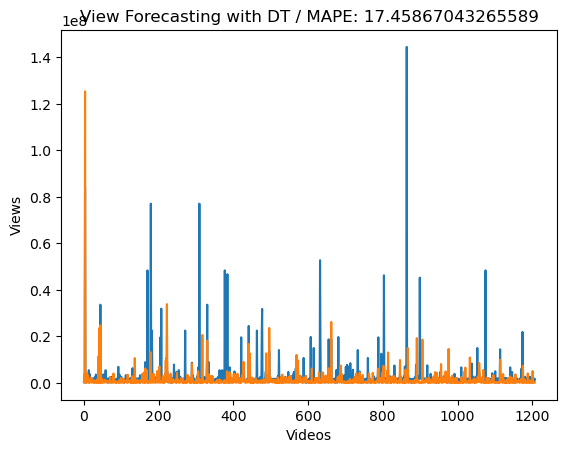

In [16]:
plt.plot(original_pred)
plt.plot(original_targets)
plt.title('View Forecasting with DT / MAPE: '+ str(mape))
plt.xlabel('Videos')
plt.ylabel('Views')
plt.show()

### Check Feature Importance

Die Implementierung des Decicion Trees der Sklearn Bibliothek ermöglicht es, die Feature Importance zu evaluieren. Dafür müssen die in mehrere Spalten aufgeteilten Features wieder kombiniert werden. 

In [17]:
# Create a DataFrame with Feature Importances
feature_importances = regressor.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

importance_df = importance_df.transpose()
importance_df.columns = importance_df.iloc[0]
importance_df = importance_df.drop('Feature')

# Sum encoded columns
column_list = ['tags_\d+','channel_title_\d+','description_\d+','title_\d+']

for i in column_list:

    filter_columns = importance_df.filter(regex=i)

    # Replace encoded columns with aggregated column
    importance_df = importance_df.drop(filter_columns, axis=1)
    importance_df[i[:-4]] = filter_columns.sum(axis=1)

# Clean importance_df for visualization
importance_df = importance_df.transpose()
importance_df = importance_df.reset_index()
importance_df = importance_df.sort_values('Importance', ascending=False)

importance_df

,Feature,Importance
2,description,0.771638
3,title,0.124852
0,tags,0.093399
1,channel_title,0.010111


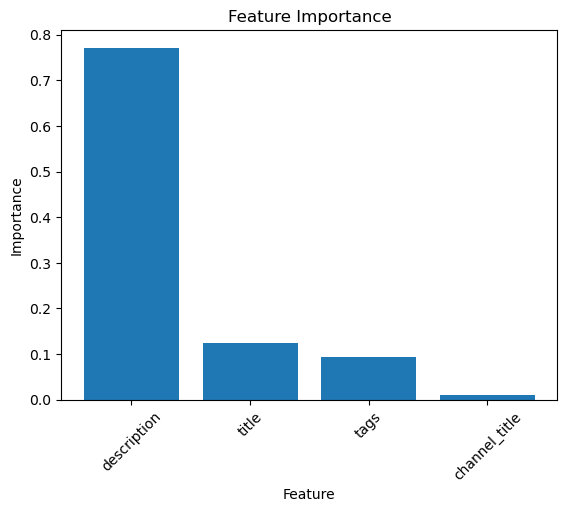

In [18]:
# Create plot of feature importances

plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()

In [19]:
# Save results for comparison

# Load the df
df = pd.read_csv('results_tra.csv')

# Add a new column
df['traditional_transfer_2000000'] = pred

# Save the modified df
df.to_csv('results_tra.csv', index=False)
